In [178]:
import os
import re
import random
import pandas as pd
import numpy as np
import json
import unicodedata
from tqdm import tqdm
from ast import literal_eval

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import chisquare

import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM

In [7]:
# 난수 고정
def set_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)

set_seed(42) # magic number :)

### Dataset
1. 변수
    - id: 고유 id
    - paragraph: 지문
    - problems: 'question', 'choices', 'answer' key를 가진 dictionary
        - question: 질문
        - choices: 선지
        - answer: 정답
    - question_plus: 보기

In [52]:
ROOT_DIR = '/data/ephemeral/pro-nlp-generationfornlp-nlp-13'
DATA_DIR = os.path.join(ROOT_DIR, 'data')
dataset = pd.read_csv(os.path.join(DATA_DIR,'train.csv'))
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2031 entries, 0 to 2030
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2031 non-null   object 
 1   paragraph      2031 non-null   object 
 2   problems       2031 non-null   object 
 3   question_plus  0 non-null      float64
dtypes: float64(1), object(3)
memory usage: 63.6+ KB


In [13]:
# Flatten the JSON dataset
records = []
for _, row in dataset.iterrows():
    problems = literal_eval(row['problems'])
    record = {
        'id': row['id'],
        'paragraph': row['paragraph'],
        'question': problems['question'],
        'choices': problems['choices'],
        'answer': problems.get('answer', None),
        "question_plus": problems.get('question_plus', None),
    }
    # Include 'question_plus' if it exists
    if 'question_plus' in problems:
        record['question_plus'] = problems['question_plus']
    records.append(record)
        
# Convert to DataFrame
df = pd.DataFrame(records)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2031 entries, 0 to 2030
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             2031 non-null   object
 1   paragraph      2031 non-null   object
 2   question       2031 non-null   object
 3   choices        2031 non-null   object
 4   answer         2031 non-null   int64 
 5   question_plus  0 non-null      object
dtypes: int64(1), object(5)
memory usage: 95.3+ KB


In [15]:
df.head()

,id,paragraph,question,choices,answer,question_plus
0,generation-for-nlp-425,"상소하여 아뢰기를 , “신이 좌참 찬 송준길이 올린 차자를 보았는데 , 상복(喪服)...",상소한 인물이 속한 붕당에 대한 설명으로 옳은 것만을 모두 고르면?,"[ㄱ, ㄴ, ㄱ, ㄷ, ㄴ, ㄹ, ㄷ, ㄹ]",2,None
1,generation-for-nlp-426,"(가)은/는 의병계열과 애국계몽 운동 계열의 비밀결사가 모여 결성된 조직으로, 총사...",(가)에 대한 설명으로 옳지 않은 것은?,"[고려 문종 때에 남경(南京)으로 승격되었다., 종루(鐘樓), 이현, 칠패 등에서 ...",1,None
2,generation-for-nlp-427,나는 삼한(三韓) 산천의 음덕을 입어 대업을 이루었다.(가)는/은 수덕(水德)이 순...,(가) 지역에 대한 설명으로 옳은 것은?,"[이곳에 대장도감을 설치하여 재조대장경을 만들었다., 지눌이 이곳에서 수선사 결사운...",4,None
3,generation-for-nlp-428,이 날 소정방이 부총관 김인문 등과 함께 기 벌포에 도착하여 백제 군사와 마주쳤다....,밑줄 친 ‘그’에 대한 설명으로 옳은 것은?,"[살수에서 수의 군대를 물리쳤다 ., 김춘추 의 신라 왕위 계승을 지원하였다 ., ...",2,None
4,generation-for-nlp-429,"선비들 수만 명이 대궐 앞에 모여 만 동묘와 서원을 다시 설립할 것을 청하니, (가...",(가) 인물이 추진한 정책으로 옳지 않은 것은?,"[사창제를 실시하였다 ., 대전회통을 편찬하였다 ., 비변사의 기능을 강화하였다 ....",3,None


In [49]:
df.iloc[0,1]

'상소하여 아뢰기를 , “신이 좌참 찬 송준길이 올린 차자를 보았는데 , 상복(喪服) 절차에 대하여 논한 것이 신과는 큰 차이가 있었습니다 . 장자를 위하여 3년을 입는 까닭은 위로 ‘정체(正體)’가 되기 때문이고 또 전 중(傳重: 조상의 제사나 가문의 법통을 전함)하기 때문입니다 . …(중략) … 무엇보다 중요한 것은 할아버지와 아버지의 뒤를 이은 ‘정체’이지, 꼭 첫째이기 때문에 참 최 3년 복을 입는 것은 아닙니다 .”라고 하였다 .－현종실록 －ㄱ.기 사환국으로 정권을 장악하였다 .ㄴ.인 조반정을 주도 하여 집권세력이 되었다 .ㄷ.정조 시기에 탕평 정치의 한 축을 이루었다 .ㄹ.이 이와 성혼의 문인을 중심으로 형성되었다.'

### choices
- 선지의 개수가 4개, 5개로 구분되어 있음

In [29]:
df['choices_len'] = df['choices'].apply(lambda x: len(x))

In [30]:
df['choices_len'].value_counts(dropna=False)

choices_len
5    1239
4     792
Name: count, dtype: int64

### Paragraph

In [22]:
df['paragraph_len'] = df['paragraph'].apply(lambda x: len(x))
df['paragraph_len'].describe()

count    2031.000000
mean      735.324471
std       462.595621
min        15.000000
25%       407.500000
50%       699.000000
75%      1014.500000
max      2017.000000
Name: paragraph_len, dtype: float64

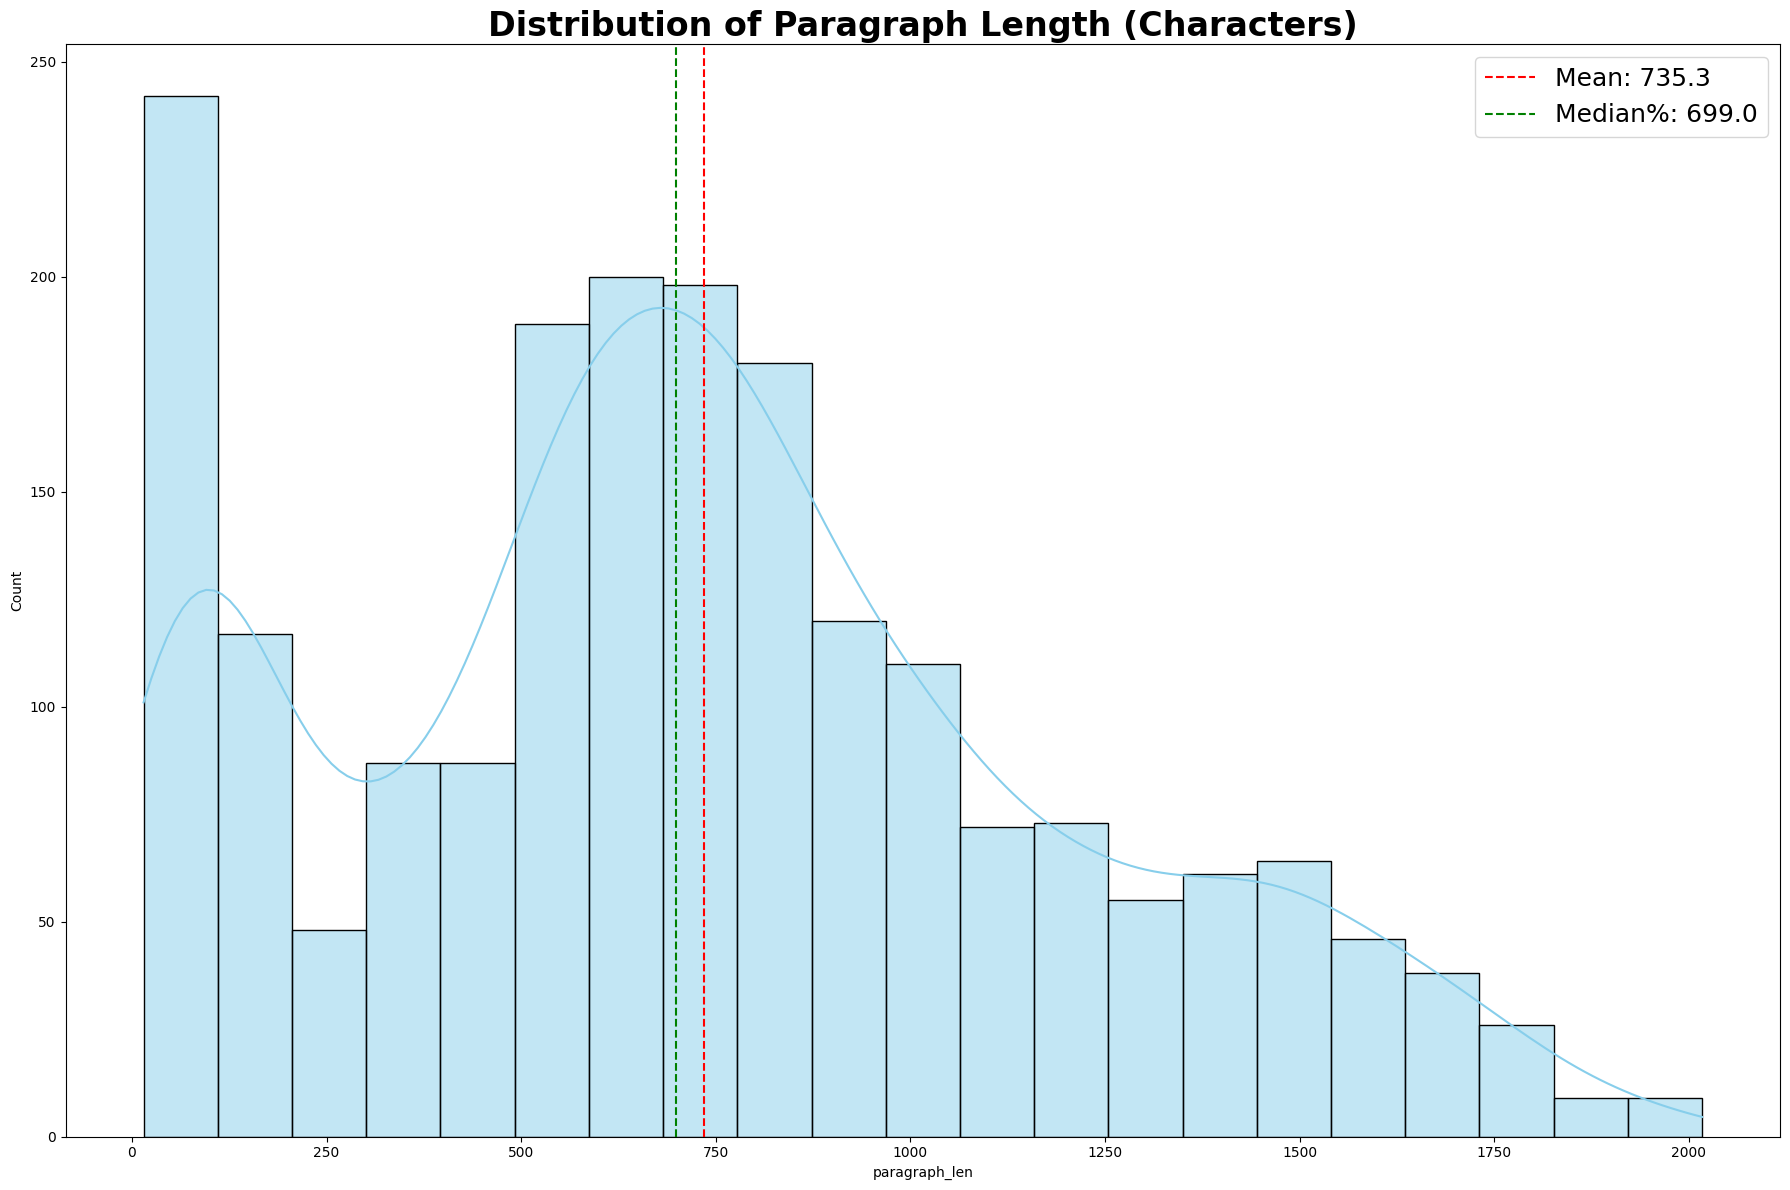

In [34]:
fig, ax = plt.subplots(figsize=(18, 12))
ax.set_title('Distribution of Paragraph Length (Characters)', fontsize=24, weight='bold')

sns.histplot(df['paragraph_len'], kde=True, ax=ax, color='skyblue')

ax.axvline(df['paragraph_len'].mean(), color='red', linestyle='--',
           label=f"Mean: {df['paragraph_len'].mean():.1f}")
ax.axvline(df['paragraph_len'].quantile(0.5), color='green', linestyle='--',
           label=f"Median%: {df['paragraph_len'].quantile(0.5):.1f}")

ax.legend(fontsize=18)
plt.tight_layout()
plt.show()

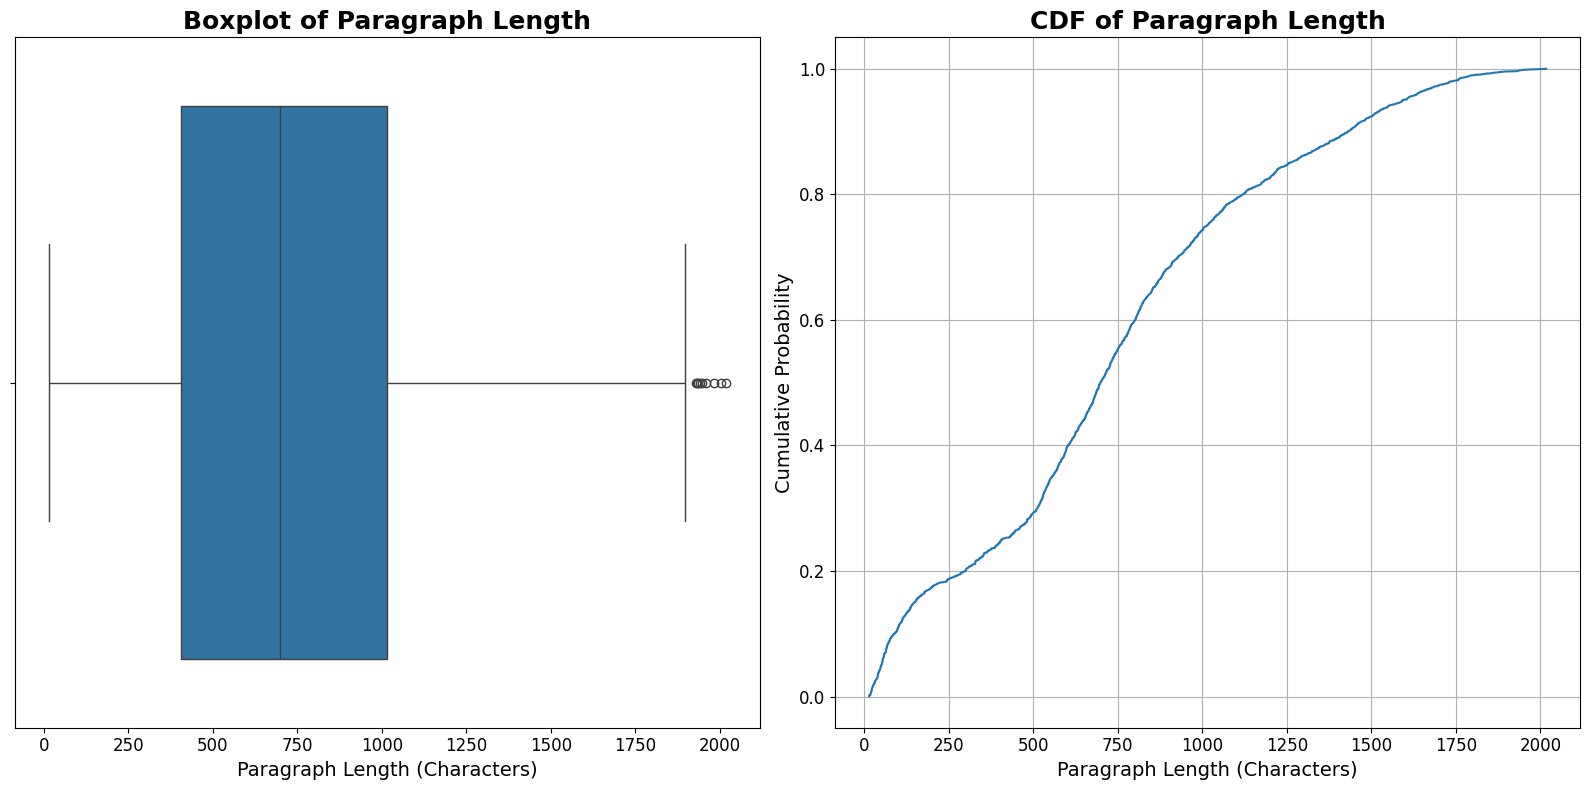

In [37]:
x = df["paragraph_len"].dropna().to_numpy()

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Boxplot
sns.boxplot(x=x, ax=axes[0])
axes[0].set_title("Boxplot of Paragraph Length", fontsize=18, weight="bold")
axes[0].set_xlabel("Paragraph Length (Characters)", fontsize=14)
axes[0].tick_params(axis='both', labelsize=12)

# CDF
sorted_x = np.sort(x)
cdf = np.arange(1, len(sorted_x) + 1) / len(sorted_x)

axes[1].plot(sorted_x, cdf)
axes[1].set_title("CDF of Paragraph Length", fontsize=18, weight="bold")
axes[1].set_xlabel("Paragraph Length (Characters)", fontsize=14)
axes[1].set_ylabel("Cumulative Probability", fontsize=14)
axes[1].tick_params(axis='both', labelsize=12)
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [70]:
### 선지 별 분석
group_stats = df.groupby('choices_len')['paragraph_len'].describe()

# 보기 좋게 출력
group_stats

,count,mean,std,min,25%,50%,75%,max
choices_len,,,,,,,,
4,792.0,319.986111,256.084661,15.0,85.75,285.5,500.25,1292.0
5,1239.0,1000.819209,357.898774,503.0,711.50,909.0,1252.00,2017.0


In [75]:
# 4지선다 중 가장 긴 것 확인 (어떤 내용이길래?)
print("=== 4지선다 샘플 ===")
print(df[df['choices_len'] == 4].sort_values('paragraph_len', ascending=False).iloc[0]['paragraph'])

# 5지선다 중 평균 길이 확인
print("\n=== 5지선다 샘플 ===")
print(df[df['choices_len'] == 5].iloc[0]['paragraph'])

=== 4지선다 샘플 ===
캉디드는 “하지만, 존경하는 팡글로스,” “내가 어떻게 당신을 다시 볼 수 있겠습니까?”라고 말하였습니다. 팡글로스가 말하길 “당신이 나의 교수형을 본 것은 사실입니다&…외과의사가 내 시신을 사서, 집으로 가져간 뒤 해부하였습니다. 그는 배꼽부터 쇄골까지 내 몸을 십자절개하기 시작했습니다. 나보다 더 심하게 교수형을 당한 사람 없을 겁니다. 종교재판의 집행관은 차보제로 그는 사람들을화형시키는 법을 기가막힐 정도로 잘 알고 있었지만 교수형에는 익숙치 않았습니다. 줄은 젖어서 제대로 풀리지 않은 데다가 단단히 묶여 있었습니다; 한마디로, 나는 여전히 숨이 붙어 있어서, 십자절개를 할 때 끔찍한 비명을 질러 나를 해부한 외과의사를 뒤로 넘어가게 했어요&…[상세히] 내 상처를 봉합했으며; 그의 부인은 나를 간호해주었습니다. 15일이 지날 무렵 나는 회복했습니다&…. 어느날 갑자기 모스크에 들어갈 결심을 하였습니다, 그 곳에서 나이 든 이만(lman)과 주기도문을 외우는 아름다운 젊은 여신도를 보았습니다&…그녀가 부케를 떨어뜨렸으며; 나는 그것을 주어서 공손히 그녀에게 주었습니다. 그것을 전달하는 데 시간이 많이 지체되어 이만은 화가 났으며, 내가 기독교인걸 보고 그는 도움을 요청했습니다. 그들은 나를 카디 앞에 데려갔으며, 그는 내 발바닥 백 대를 때릴 것을 명령하고 나를 갤러리선으로 보냈습니다. 나는 젋은 남작과 같은 갤러리선의 같은 벤치에 묶였습니다. 이 갤러리선에는 마르세유 출신의 4명의 젋은 남성과 나폴리칸 출신의 성직자 5명, 그리고 코푸 출신의 2명의 수도승이 있었으며, 수도승들은 매일 비슷한 모험담들을 우리에게 얘기해 주었습니다. 남작은 자신이 나보다 훨씬 더 부당한 일들을 겪었다고 주장했습니다&…우리는 끊임없이 논쟁했으며, 공통적인 사건들을 연속적으로 갤러리선에 일으켰기 때문에 소의 음경으로 만든 채찍 이대를 맞았으며, 그리고 당신의 우리의 몸값을 지불할만큼 충분히 좋은 사람이었습니다.” 칸디는 “글쎄요, 존경하는 팡글로스,

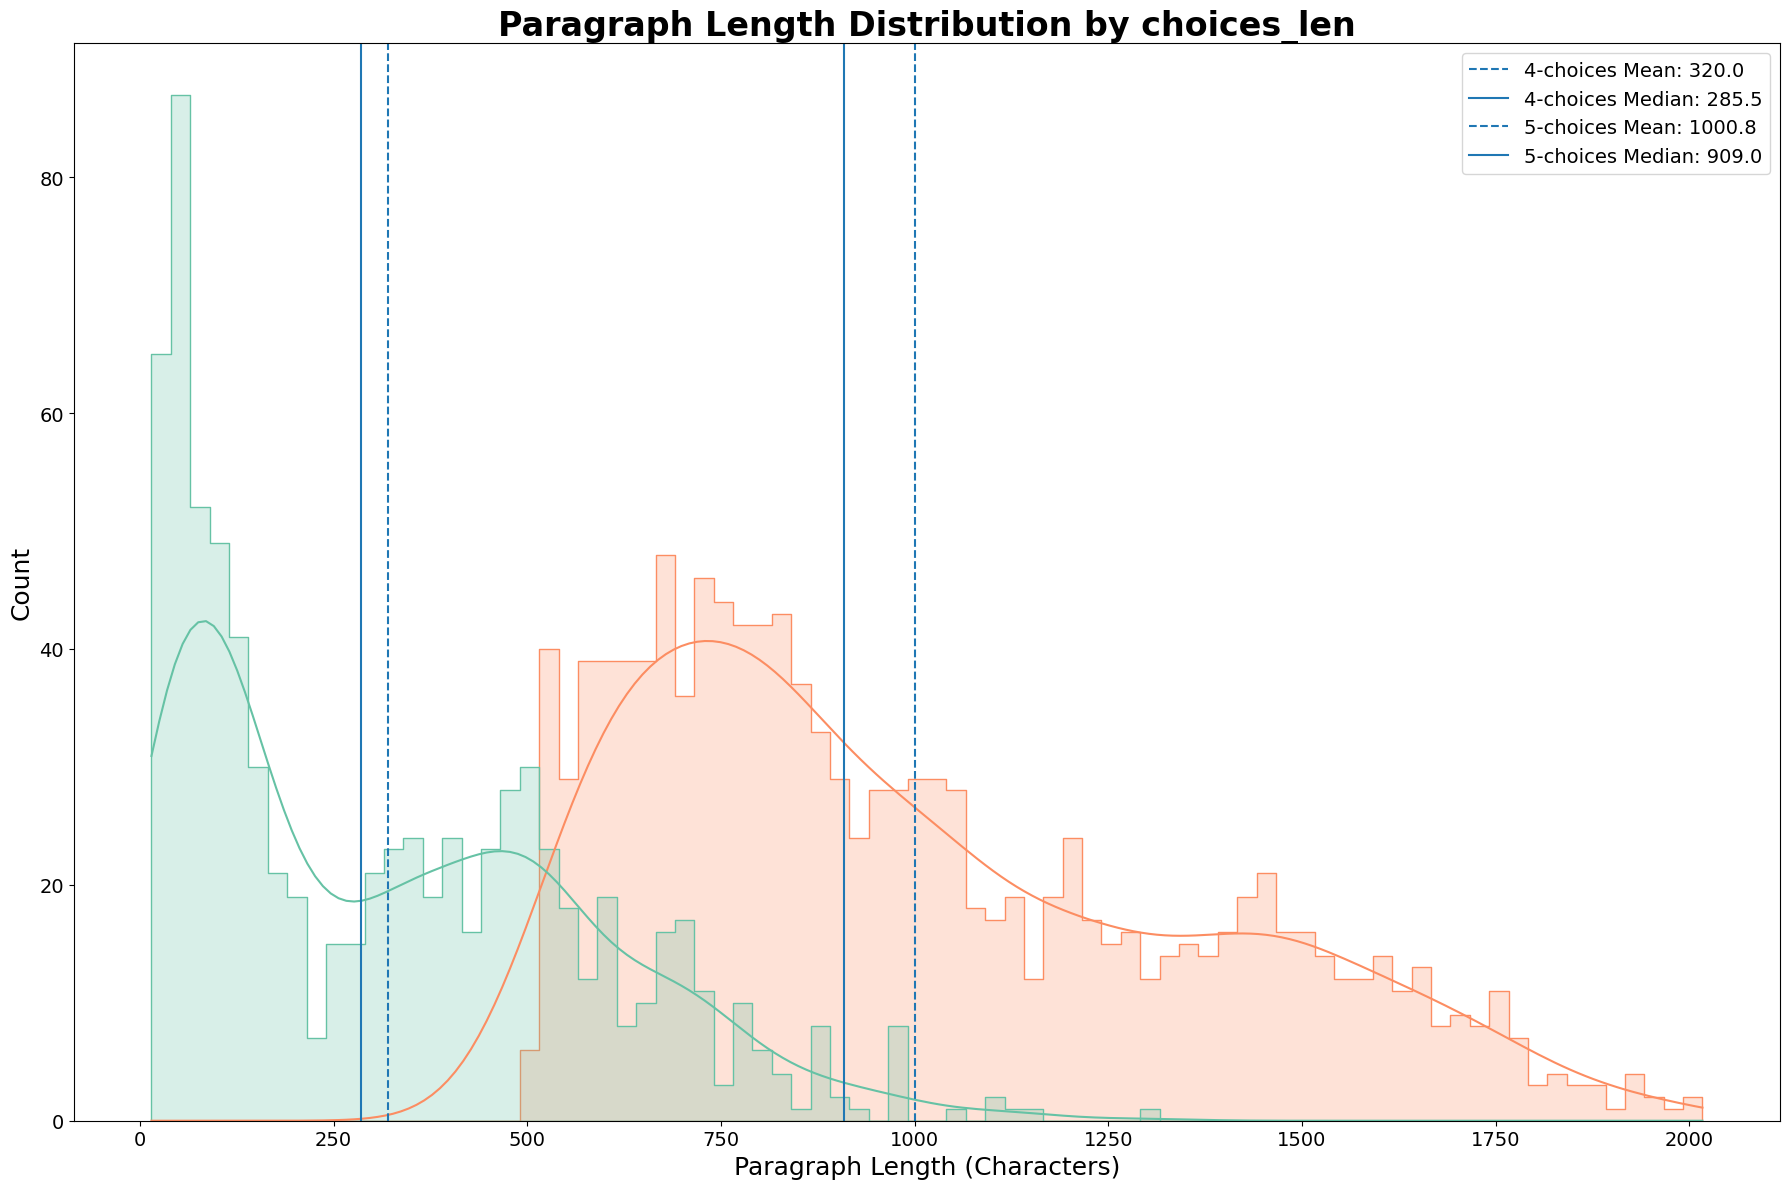

In [90]:
fig, ax = plt.subplots(figsize=(18, 12))
ax.set_title('Paragraph Length Distribution by choices_len', fontsize=24, weight='bold')
ax.set_xlabel('Paragraph Length (Characters)', fontsize=18)
ax.set_ylabel('Count', fontsize=18)

sns.histplot(
    data=df, x='paragraph_len', hue='choices_len',
    bins=80, kde=True, multiple='layer', element='step', palette="Set2",
    ax=ax
)

for cl, g in df.groupby('choices_len'):
    ax.axvline(g['paragraph_len'].mean(), linestyle='--',
               label=f"{cl}-choices Mean: {g['paragraph_len'].mean():.1f}")
    ax.axvline(g['paragraph_len'].median(), linestyle='-',
               label=f"{cl}-choices Median: {g['paragraph_len'].median():.1f}")

ax.tick_params(axis='both', labelsize=14)
ax.legend(fontsize=14)
plt.tight_layout()
plt.show()

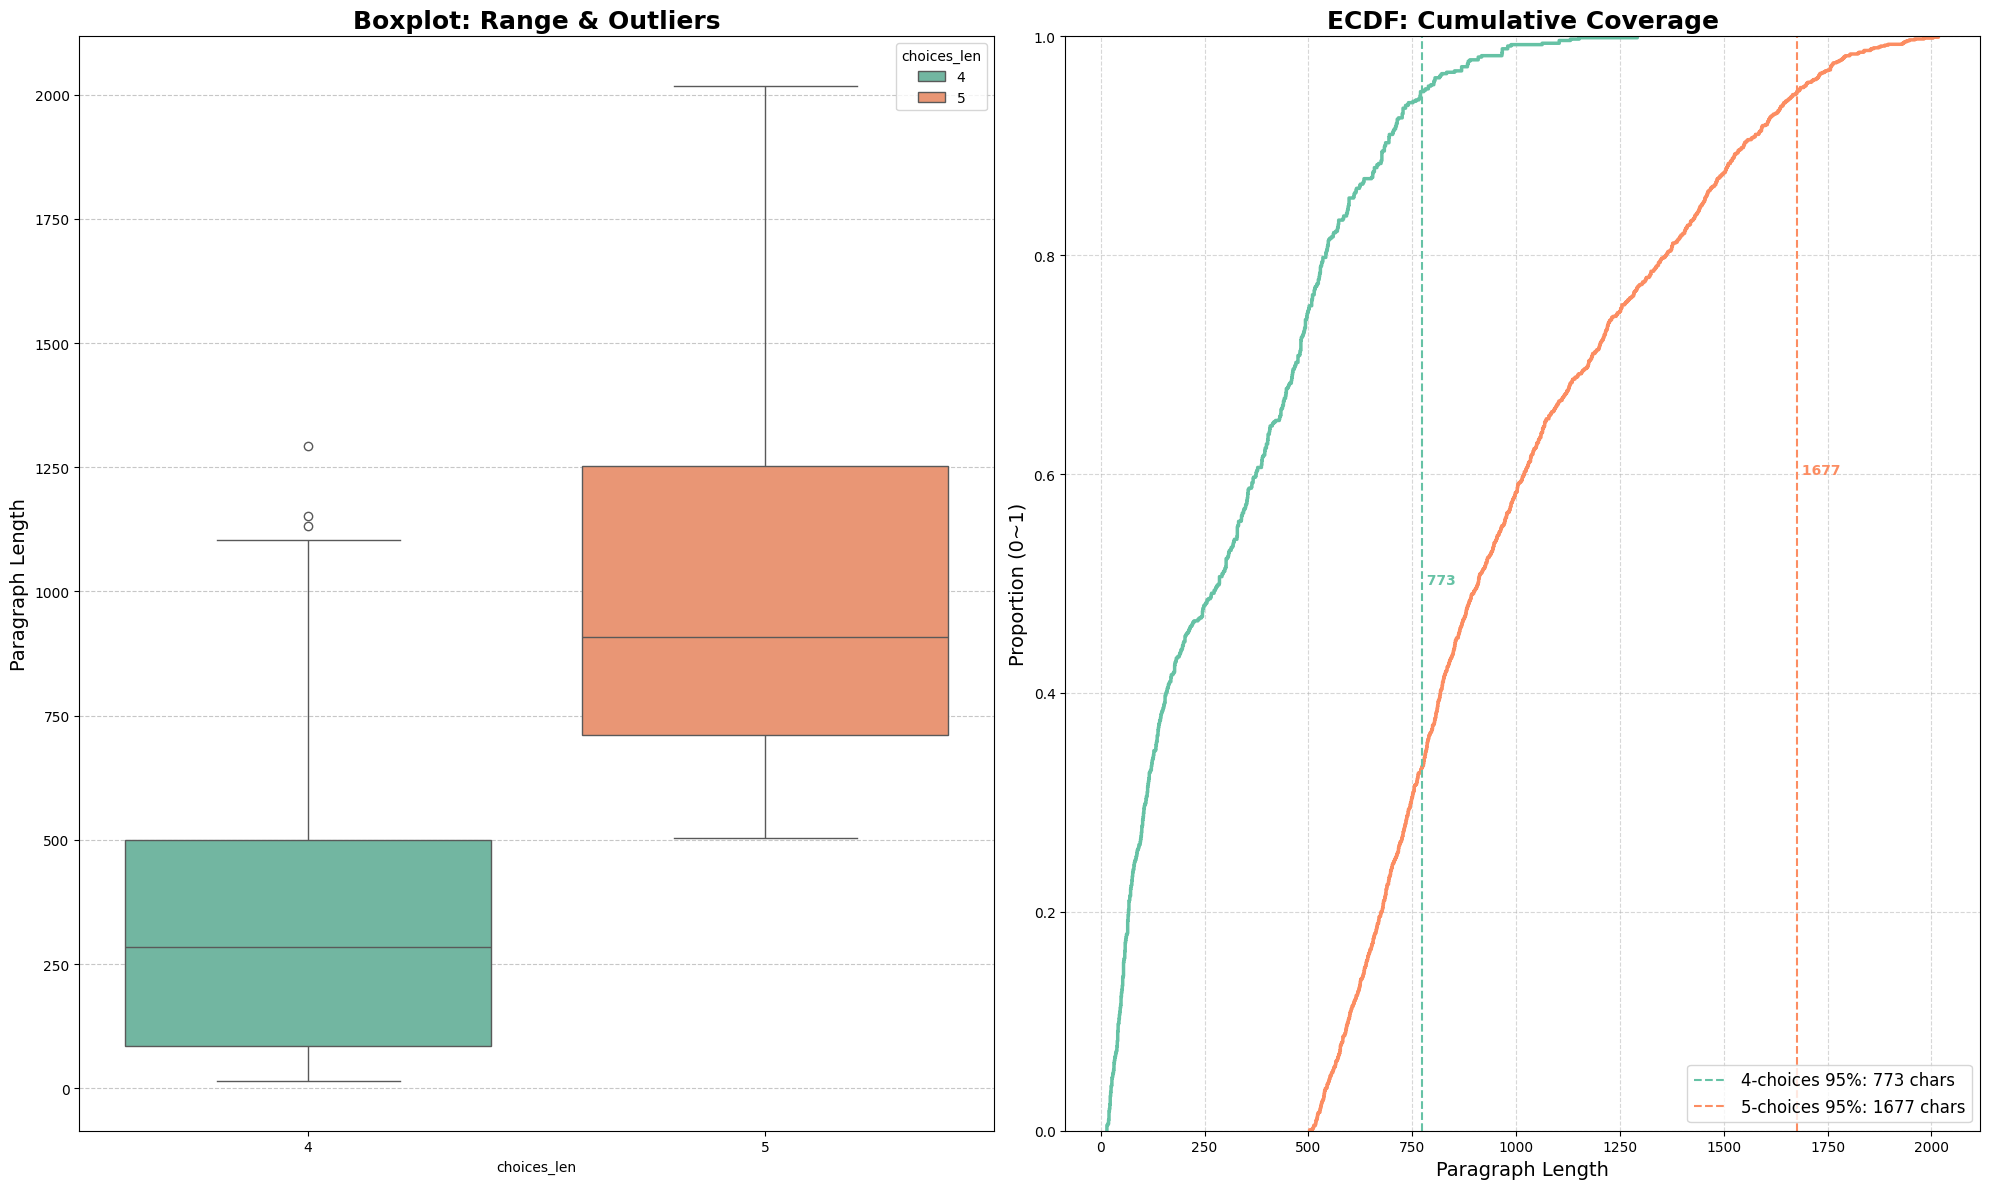

In [88]:
fig, axes = plt.subplots(1, 2, figsize=(20, 12))

## Boxplot
sns.boxplot(
    data=df, x='choices_len', y='paragraph_len', 
    ax=axes[0], palette="Set2",  hue="choices_len"
)
axes[0].set_title('Boxplot: Range & Outliers', fontsize=18, weight='bold')
axes[0].set_ylabel('Paragraph Length', fontsize=14)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

## CDF 
sns.ecdfplot(
    data=df, x='paragraph_len', hue='choices_len', 
    ax=axes[1], palette="Set2", linewidth=2.5
)
axes[1].set_title('ECDF: Cumulative Coverage', fontsize=18, weight='bold')
axes[1].set_xlabel('Paragraph Length', fontsize=14)
axes[1].set_ylabel('Proportion (0~1)', fontsize=14)
axes[1].grid(True, linestyle='--', alpha=0.5)

percentile_95 = df.groupby('choices_len')['paragraph_len'].quantile(0.95)
colors = sns.color_palette("Set2", 2) 

for i, (choice_n, p95) in enumerate(percentile_95.items()):
    axes[1].axvline(p95, color=colors[i], linestyle='--', label=f'{choice_n}-choices 95%: {int(p95)} chars')
    axes[1].text(p95, 0.5 + (i*0.1), f' {int(p95)}', color=colors[i], fontweight='bold')

axes[1].legend(fontsize=12, loc='lower right')

plt.tight_layout()
plt.show()

### answer

In [92]:
df['answer'].value_counts()

answer
1    948
2    450
3    319
4    283
5     31
Name: count, dtype: int64

In [107]:
df.groupby(['choices_len','answer']).size().reset_index(name='count')

,choices_len,answer,count
0,4,1,183
1,4,2,185
2,4,3,203
3,4,4,221
4,5,1,765
5,5,2,265
6,5,3,116
7,5,4,62
8,5,5,31


In [108]:
tmp = (
    df.groupby(['choices_len', 'answer'])
      .size()
      .reset_index(name='count')
)

tmp['pct_within_choices_len'] = (
    tmp['count'] / tmp.groupby('choices_len')['count'].transform('sum') * 100
)

tmp.sort_values(['choices_len', 'count'], ascending=[True, False])

,choices_len,answer,count,pct_within_choices_len
3,4,4,221,27.904040
2,4,3,203,25.631313
1,4,2,185,23.358586
0,4,1,183,23.106061
4,5,1,765,61.743341
5,5,2,265,21.388216
6,5,3,116,9.362389
7,5,4,62,5.004036
8,5,5,31,2.502018


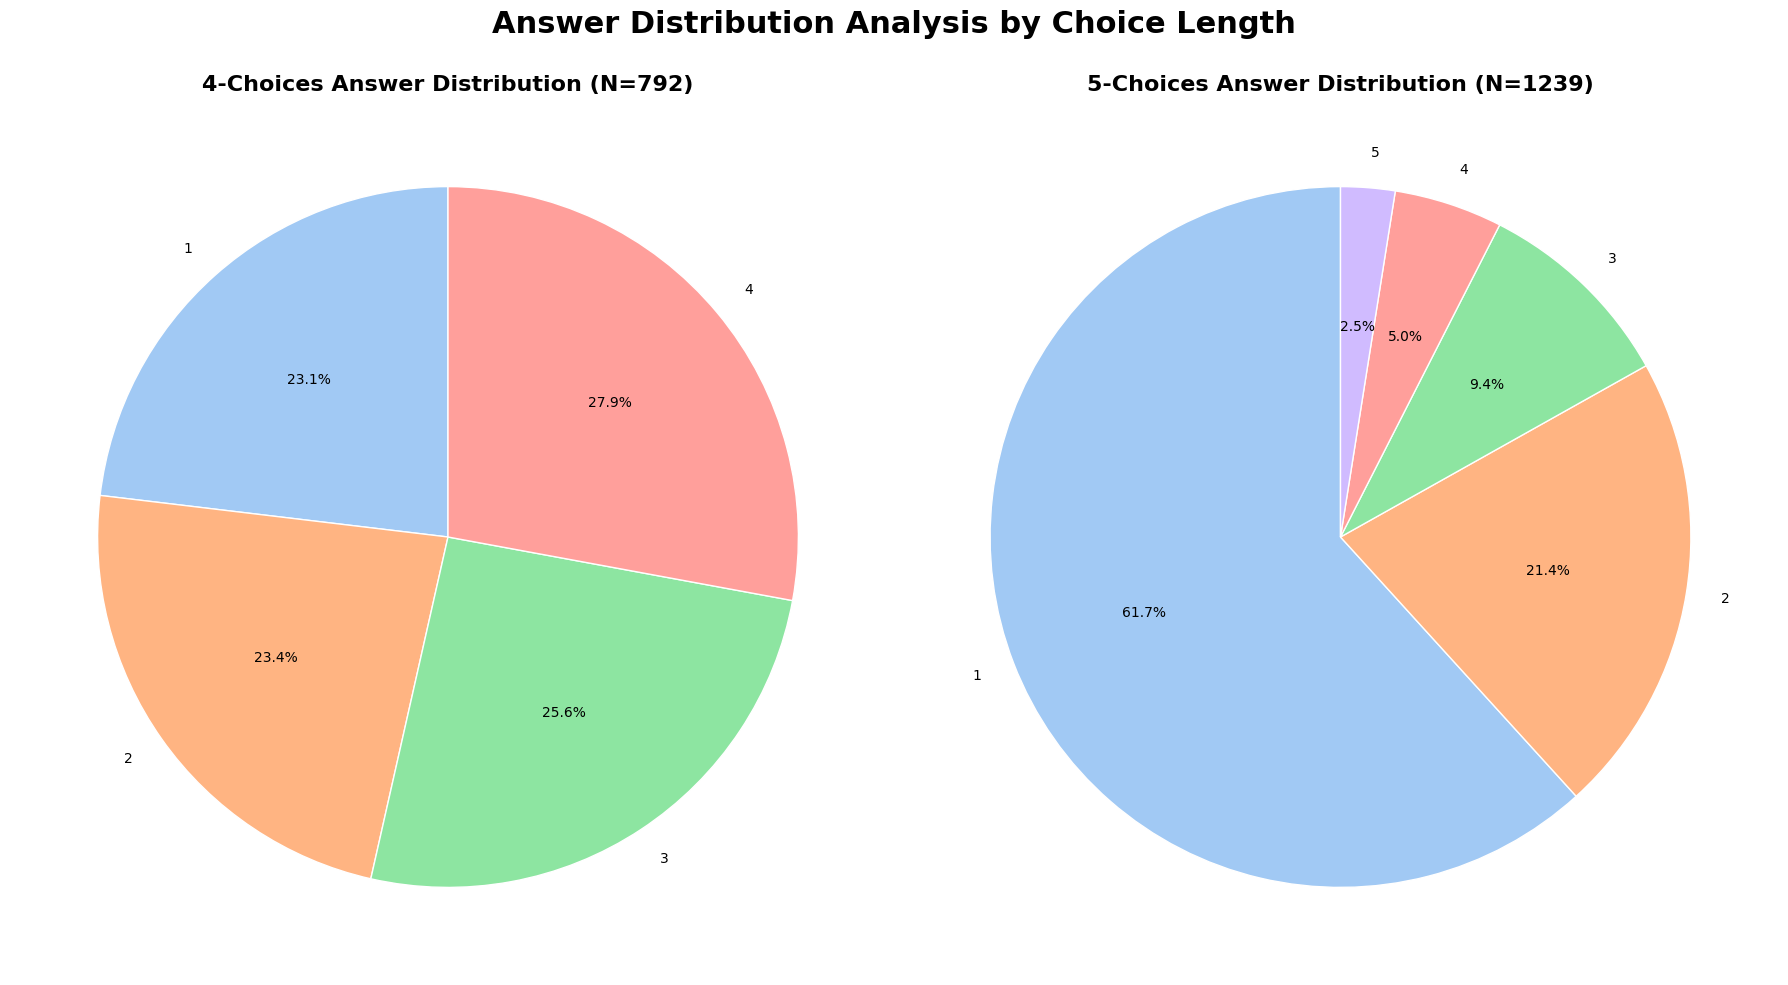

In [117]:
fig, axes = plt.subplots(1, 2, figsize=(18, 10))
plt.suptitle('Answer Distribution Analysis by Choice Length', fontsize=22, weight='bold')

colors = sns.color_palette('pastel')

# 4지선다
df_4 = df[df['choices_len'] == 4]
if not df_4.empty:
    counts_4 = df_4['answer'].value_counts().sort_index()
    axes[0].pie(counts_4, labels=counts_4.index, autopct='%1.1f%%',
                startangle=90, colors=colors, wedgeprops={'edgecolor': 'white'})
    axes[0].set_title(f'4-Choices Answer Distribution (N={len(df_4)})', fontsize=16, weight='bold')
else:
    axes[0].text(0.5, 0.5, 'No Data', ha='center', va='center')

# 5지선다
df_5 = df[df['choices_len'] == 5]
if not df_5.empty:
    counts_5 = df_5['answer'].value_counts().sort_index()
    axes[1].pie(counts_5, labels=counts_5.index, autopct='%1.1f%%',
                startangle=90, colors=colors, wedgeprops={'edgecolor': 'white'})
    axes[1].set_title(f'5-Choices Answer Distribution (N={len(df_5)})', fontsize=16, weight='bold')
else:
    axes[1].text(0.5, 0.5, 'No Data', ha='center', va='center')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

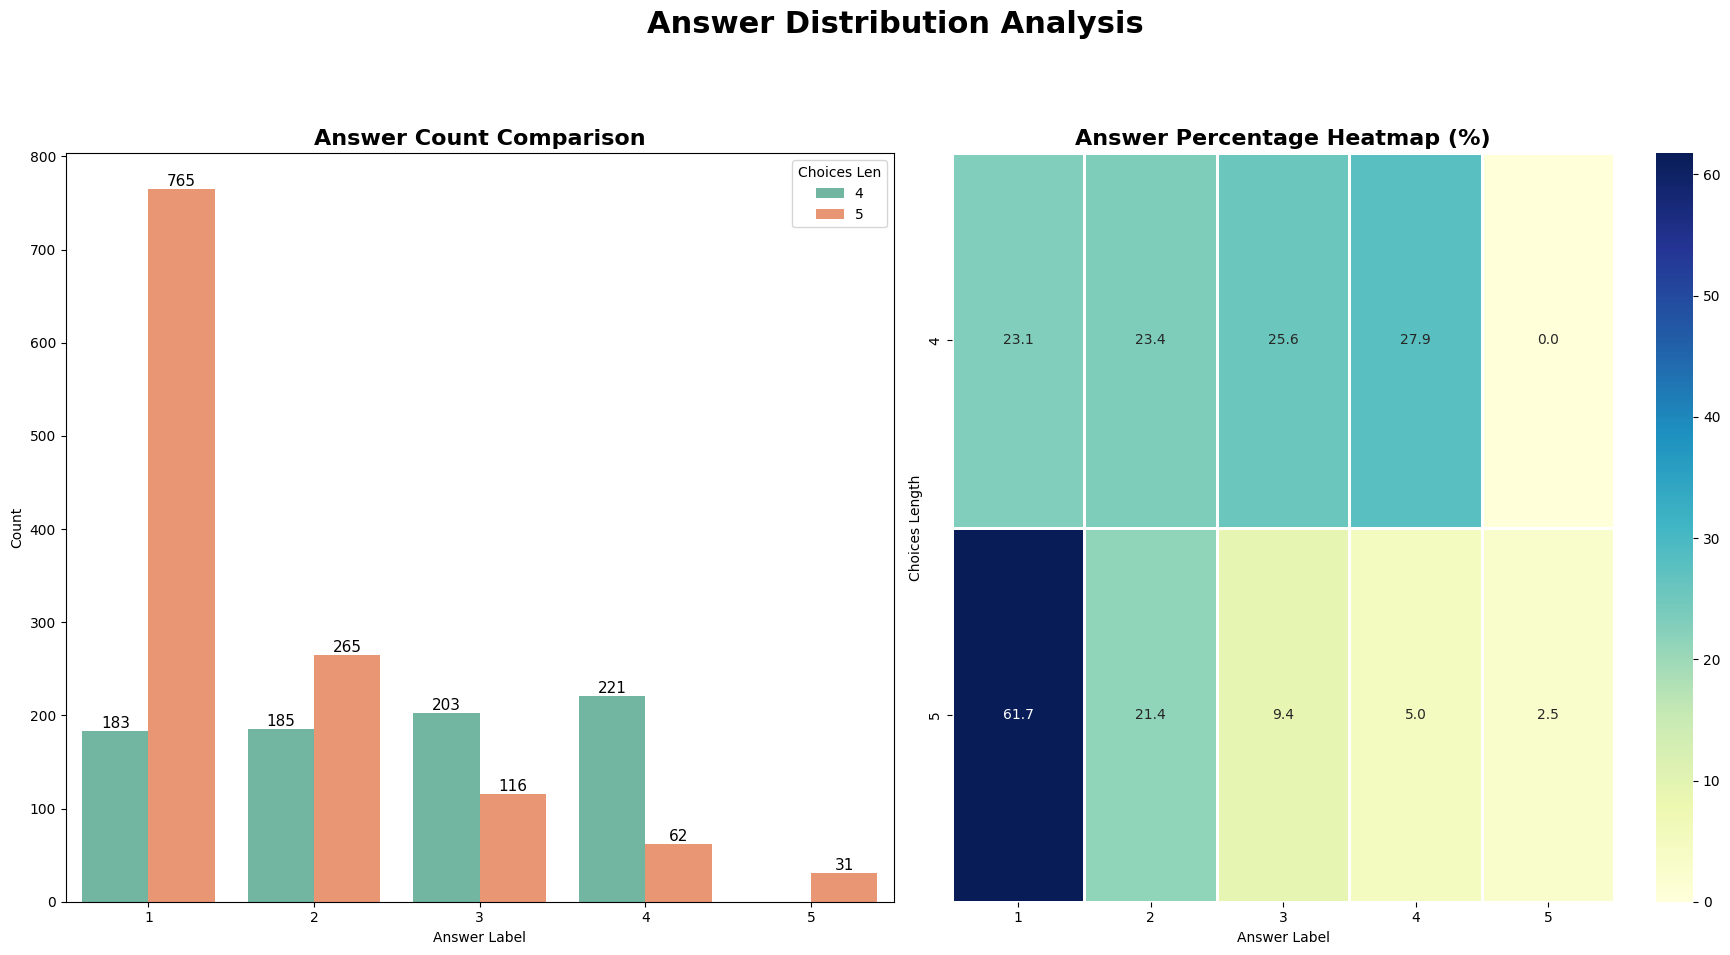

In [120]:
fig, axes = plt.subplots(1, 2, figsize=(18, 10))
plt.suptitle('Answer Distribution Analysis', fontsize=22, weight='bold')

sns.countplot(x='answer', hue='choices_len', data=df, ax=axes[0], palette='Set2')
axes[0].set_title('Answer Count Comparison', fontsize=16, weight='bold')
axes[0].set_xlabel('Answer Label')
axes[0].set_ylabel('Count')
axes[0].legend(title='Choices Len')

for p in axes[0].patches:
    height = p.get_height()
    if height > 0:
        axes[0].annotate(
            f'{int(height)}',
            (p.get_x() + p.get_width() / 2., height),
            ha='center', va='bottom', fontsize=11
        )

## Heatmap
crosstab = pd.crosstab(df['choices_len'], df['answer'], normalize='index') * 100
sns.heatmap(
    crosstab, annot=True, fmt='.1f', cmap='YlGnBu',
    cbar=True, ax=axes[1], linewidths=1, linecolor='white'
)
axes[1].set_title('Answer Percentage Heatmap (%)', fontsize=16, weight='bold')
axes[1].set_ylabel('Choices Length')
axes[1].set_xlabel('Answer Label')

plt.tight_layout(rect=[0, 0.03, 1, 0.92])
plt.show()-

### 검증
- H_0: 정답 분포가 균등하다
    - 4지선다: p_1=p_2=p_3=p_4=0.25
    - 5지선다: p_1=p_2=p_3=p_4=p_5=0.20
- H_1: 정답 분포가 균등하지 않다

In [129]:
print("=== 4지선다 데이터 적합도 검정 ===")
df_4 = df[df['choices_len'] == 4]
observed_4 = df_4['answer'].value_counts().sort_index().values
expected_4 = [len(df_4) / 4] * 4

chi2_stat_4, p_val_4 = chisquare(f_obs=observed_4, f_exp=expected_4)

print(f"관측된 빈도: {observed_4}")
print(f"기대 빈도: {expected_4[0]:.1f} (각 선지당)")
print(f"Chi2 통계량: {chi2_stat_4:.4f}")
print(f"P-value: {p_val_4:.10f}")

if p_val_4 < 0.05:
    print(">> 결과: 귀무가설 기각 (p < 0.05). 정답 분포가 균등하지 않습니다. (편향 존재)")
else:
    print(">> 결과: 귀무가설 채택. 정답 분포가 균등합니다.")



=== 4지선다 데이터 적합도 검정 ===
관측된 빈도: [183 185 203 221]
기대 빈도: 198.0 (각 선지당)
Chi2 통계량: 4.7879
P-value: 0.1880051609
>> 결과: 귀무가설 채택. 정답 분포가 균등합니다.


5지선다 데이터 (choices_len = 5)
- 관측 빈도: [765, 265, 116, 62, 31]
- 기대 빈도: 각 선택지당 247.8
- $$\chi^2 = 1479.7692$$
- $$p \approx 0.0000 (유의수준 0.05에서 매우 작음)$$

In [127]:
print("=== 5지선다 데이터 적합도 검정 ===")
df_5 = df[df['choices_len'] == 5]
observed_5 = df_5['answer'].value_counts().sort_index().values
expected_5 = [len(df_5) / 5] * 5

chi2_stat_5, p_val_5 = chisquare(f_obs=observed_5, f_exp=expected_5)

print(f"관측된 빈도: {observed_5}")
print(f"기대 빈도: {expected_5[0]:.1f} (각 선지당)")
print(f"Chi2 통계량: {chi2_stat_5:.4f}")
print(f"P-value: {p_val_5:.4f}")

if p_val_5 < 0.05:
    print(">> 결과: 귀무가설 기각 (p < 0.05). 정답 분포가 균등하지 않습니다.")
else:
    print(">> 결과: 귀무가설 채택 (p > 0.05). 정답 분포가 통계적으로 균등하다고 볼 수 있습니다.")

=== 5지선다 데이터 적합도 검정 ===
관측된 빈도: [765 265 116  62  31]
기대 빈도: 247.8 (각 선지당)
Chi2 통계량: 1479.7692
P-value: 0.0000
>> 결과: 귀무가설 기각 (p < 0.05). 정답 분포가 균등하지 않습니다.



### 데이터 구성 가설 (Data Composition Hypothesis)
데이터는 생성 출처와 방식에 따라 명확하게 두 그룹으로 이원화 되어 있음

| 구분 | **Group A (4지선다)** | **Group B (5지선다)** |
| :--- | :--- | :--- |
| **추정 출처** | **KMMLU, MMLU 등** (기존 벤치마크) | **KLUE/MRC, 수능형 등** (독해 데이터) |
| **선지 유무** | 원본 데이터에 선지(A,B,C,D)가 존재 | 원본에 선지가 없음 (Span Extraction) |
| **가공 방식** | 기존 선지 매핑 (A→1, B→2...) | **GPT-4o-mini**가 지문 독해 후 선지 생성 |
| **특이 사항** | 정답 분포 균등(Uniform) → 기존 벤치마크 재포맷/매핑의 영향으로 보임 |  **정답 쏠림 현상 발견** |

---

#### 길이 분포의 이질성 (Length Discrepancy)

* **4지선다 (Short):** 평균 길이 약 **300자** 내외. 단문 위주의 상식/사실 검색 문제
* **5지선다 (Long):** 평균 **1,000자 이상**, 최대 **2,000자**. 긴 호흡의 독해 및 추론 문제
* **Risk:** 5지선다 데이터는 일반적인 `max_seq_length`(1024) 설정 시 **Truncation(지문 잘림) 위험**이 매우 높음

### 정답 분포와 편향성 (Label Distribution & Bias)
> 생성 방식의 차이가 정답 분포(position bias)에 직접적인 영향을 미칠 수 있음

1.  **5지선다 (Balanced):**
    * Chi-square 적합도 검정 결과, 정답 분포는 **균등** (p=0.188 > 0.05)

2.  **4지선다 (Biased):**
    * 정답이 **`1번`에 유의미하게 쏠려 있음.** ($p < 0.05$, Chi-squared Test 기각)
    * 관측 빈도에서 1번 정답이 압도적으로 높아 **정답 위치 편향(position bias)** 가능성이 큼

### 5지 선다 데이터

In [146]:
df5 = df[df["choices_len"] == 5].copy()
df5.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1239 entries, 792 to 2030
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             1239 non-null   object
 1   paragraph      1239 non-null   object
 2   question       1239 non-null   object
 3   choices        1239 non-null   object
 4   answer         1239 non-null   int64 
 5   question_plus  0 non-null      object
 6   paragraph_len  1239 non-null   int64 
 7   choices_len    1239 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 87.1+ KB


In [147]:
#### 정답 선지의 텍스트가 지문(paragraph)에 그대로 등장하는지 확인

def norm_basic(text):
    text = "" if text is None else str(text)
    text = unicodedata.normalize("NFKC", text)
    text = text.strip()
    text = re.sub(r"\s+", " ", text)
    return text

def get_answer_text(row):
    try:
        ans = int(row["answer"])
        idx = ans - 1
        choices = row["choices"]
        if not isinstance(choices, (list, tuple)) or idx < 0 or idx >= len(choices):
            return ""
        return norm_basic(choices[idx])
    except:
        return ""

df5 = df[df["choices_len"] == 5].copy()

df5["paragraph_norm"] = df5["paragraph"].map(norm_basic)
df5["answer_text"] = df5.apply(get_answer_text, axis=1)

df5["is_exact_match"] = df5.apply(
    lambda r: (r["answer_text"] != "") and (r["answer_text"] in r["paragraph_norm"]),
    axis=1
)

In [148]:
df5["is_exact_match"].mean(), df5["is_exact_match"].value_counts()

(0.6166263115415658,
 is_exact_match
 True     764
 False    475
 Name: count, dtype: int64)

In [149]:
df5.loc[df5["is_exact_match"]].sample(5, random_state=42)[["answer_text","paragraph"]]
df5.loc[~df5["is_exact_match"]].sample(5, random_state=42)[["answer_text","paragraph"]]

,answer_text,paragraph
1784,콘도는 다양한 수요층을 만족시키기 위해 객실 크기를 다양하게 꾸민다.,한때 펜션과 전원주택이 인기를 끌면서 콘도가 사양산업으로 평가됐다. 하지만 최근에는...
1895,스마트홈,이지스자산운용과 퓨처플레이가 지난 해 6월 개최한 ‘이지스-테크업플러스’ 프로그램에...
814,7만 가구,"박근혜 대통령의 공약사업으로 추진돼온 대학생과 신혼부부, 사회초년생 등을 위한 임대..."
988,"역북지구는 미니신도시로 조성되며, 용인경전철 명지대역과 연결된다.",집값에 거품이 끼었다고 지목된 ‘버블 세븐’에 포함될 정도로 부동산 호황을 누리다 ...
1734,시간은 인간이 발명한 개념이다.,휴대폰을 켜고 지금 몇 시인지 보자. 오후 1시17분과 같은 시간을 확인할 수 있을...


In [153]:
df5['question'].sample(20, random_state=42).tolist()

['진영 보건복지부 장관이 기초연금 지급 대상을 소득 하위 몇 퍼센트로 제한하는 방안을 검토한다고 밝혔는가?',
 '최근 한 달 동안 수도권에서 아파트값이 가장 많이 상승한 지역은 어디인가?',
 'NEAT 시험의 신뢰도에 영향을 미칠 것으로 예상되는 사건은 무엇인가?',
 'GM 자동차의 해킹 시연을 한 해커의 이름은 무엇인가?',
 '장시간 운전으로 인해 발생할 수 있는 척추 질환 예방을 위해 가장 중요한 것은 무엇인가?',
 '주몽이 고구려를 건국하도록 이끈 인물은 누구인가?',
 '한국도박문제관리센터가 주최하는 제5차 도박문제 포럼의 주제는 무엇인가?',
 '‘J-MIV’ 동아리의 주된 목적은 무엇인가?',
 '내년 총선에 대비하여 SOC 예산이 대폭 증액된 이유는 무엇인가?',
 '충남 논산 한국폴리텍 특성화대학 바이오캠퍼스의 올해 취업률은 얼마인가?',
 'BIS가 경고한 세계 금융시장의 문제점은 무엇인가?',
 '일본 최대 조선사인 이마바리조선이 신규 도크를 건설하기로 한 이유는 무엇인가?',
 '중국 정부가 카드 지급결제 시장을 개방하기로 결정한 이유는 무엇인가?',
 '중국의 해양감시선이 진입한 센카쿠열도의 일본명은 무엇인가?',
 '자율주행차의 도입이 기존 산업구조에 미치는 영향에 대한 저자의 주장은 무엇인가?',
 '‘미핵’이 사이버 공격을 예고한 날짜는 언제인가?',
 '윤상직 장관이 맡게 될 위스콘신대 한국 총동문회장의 직책은 무엇인가?',
 '아동폭력 옹호사업을 진행하는 초록우산어린이재단의 회장은 누구인가?',
 '인조인간 렉스의 제작에 참여한 영국의 기업 이름은 무엇인가?',
 '제주신화월드 신화테마파크에서 겨울 시즌에 진행되는 체험 중, 방어를 잡는 체험의 이름은 무엇인가?']

In [135]:
df5['paragraph_norm'].apply(lambda x: len(x)).describe()

count    1239.000000
mean     1001.411622
std       358.222307
min       503.000000
25%       711.500000
50%       908.000000
75%      1252.000000
max      2017.000000
Name: paragraph_norm, dtype: float64

In [ ]:
#### 질문 유형 분석
NEG_PAT = r"(옳지\s*않은|적절하지\s*않은|틀린\s*것|아닌\s*것|없는\s*것|해당하지\s*않는)"
WHY_PAT = r"(이유|원인|까닭|근거|왜)"
TOPIC_PAT = r"(주제|제목|요지|중심\s*내용|주장|핵심)"
HOW_PAT = r"(방법|방식|수단|조치|어떻게|과정|절차)"
APPLY_PAT = r"(사례|적용|대입|실험|상황)"

POINTER_PAT = r"(지문|위\s*글|위\s*지문|위\s*문장|위\s*문단|다음\s*글|다음\s*중|<보기>|보기|밑줄|표|그림|그래프|㉠|㉡|㉢|㉣)"

WHO_PAT = r"(누구|인물|사람|이름|회장|장관|교수|사무총장)"
WHERE_PAT = r"(어디|지역|도시|나라|장소|곳|어느\s*지역)"
WHEN_PAT = r"(언제|시기|날짜|연도|몇\s*년|몇\s*월|몇\s*일)"
NUM_PAT = r"(몇\s*퍼센트|%|퍼센트|몇\s*명|몇\s*개|몇\s*척|몇\s*구|몇\s*대|몇\s*차례|얼마|수치|비율|취업률|프레임|km)"

def classify_question_type_ko(q):
    q = str(q).strip()

    if re.search(NEG_PAT, q):
        return "NEG"
    if re.search(WHY_PAT, q):
        return "WHY"
    if re.search(TOPIC_PAT, q):
        return "TOPIC"
    if re.search(APPLY_PAT, q):
        return "APPLY"
    if re.search(POINTER_PAT, q):
        return "POINTER"

    if re.search(NUM_PAT, q):
        return "NUM"
    if re.search(WHEN_PAT, q):
        return "WHEN"
    if re.search(WHO_PAT, q):
        return "WHO"
    if re.search(WHERE_PAT, q):
        return "WHERE"

    return "OTHER_FACT"

df5["question_type"] = df5["question"].apply(classify_question_type_ko)
df5["question_type"].value_counts(dropna=False)

question_type
OTHER_FACT    333
WHY           232
NUM           182
WHO           162
WHERE          86
POINTER        66
WHEN           65
TOPIC          60
NEG            39
APPLY          14
Name: count, dtype: int64

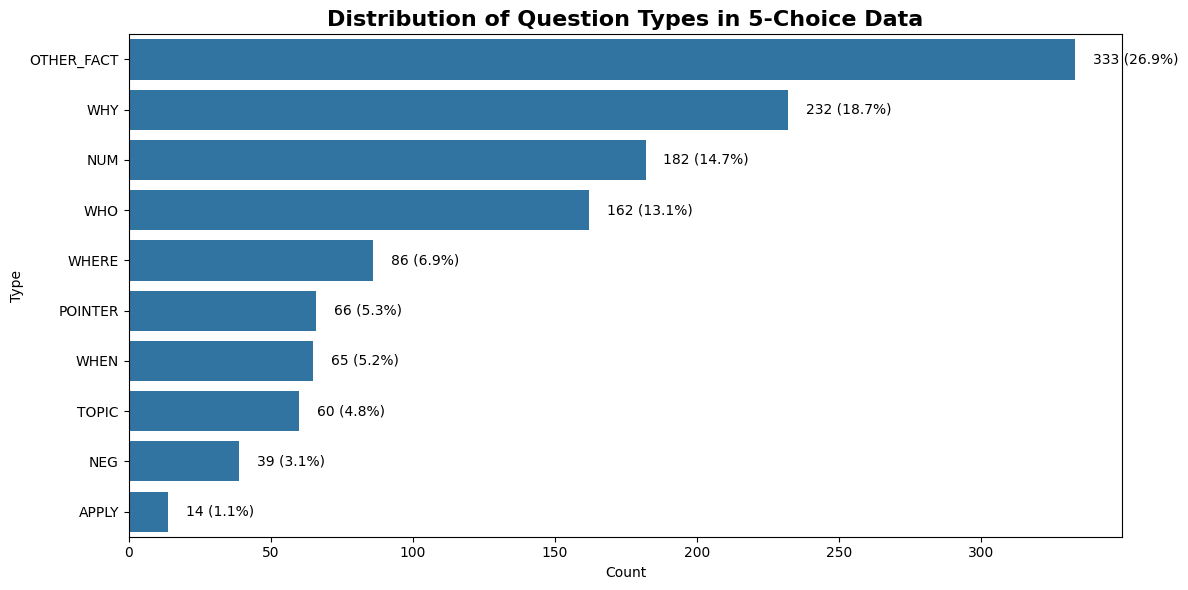

In [171]:
order = df5["question_type"].value_counts().index

plt.figure(figsize=(12, 6))
ax = sns.countplot(y="question_type", data=df5, order=order)

plt.title("Distribution of Question Types in 5-Choice Data", fontsize=16, weight="bold")
plt.xlabel("Count")
plt.ylabel("Type")

total = len(df5)
for p in ax.patches:
    w = p.get_width()
    if w > 0:
        ax.text(w + total*0.005, p.get_y() + p.get_height()/2,
                f"{int(w)} ({w/total*100:.1f}%)", va="center")

plt.tight_layout()
plt.show()

In [172]:
# OTHER_FACT에 어떤 질문들이 뭉쳐있는지 확인
print("=== [OTHER_FACT] 샘플 질문 50 ===")
other_samples = df5[df5['question_type'] == 'OTHER_FACT']['question'].sample(50, random_state=42).values

for i, q in enumerate(other_samples):
    print(f"{i+1}. {q}")

#  POINTER가 왜 4개밖에 없는지 확인
print("\n=== [POINTER] 감지된 질문들 ===")
print(df5[df5['question_type'] == 'POINTER']['question'].values)

=== [OTHER_FACT] 샘플 질문 50 ===
1. 장시간 운전으로 인해 발생할 수 있는 척추 질환 예방을 위해 가장 중요한 것은 무엇인가?
2. 태평양과 동천이 연말에 진행한 행사에서 기부금이 전달된 대상은 무엇인가?
3. 세틀뱅크와 아시아페이가 체결한 협약의 주요 목적은 무엇인가?
4. 파크맘 매칭회가 설립된 주된 목적은 무엇인가?
5. ‘J-MIV’ 동아리의 주된 목적은 무엇인가?
6. 오바마 대통령이 투자한 주식의 종류는 무엇인가?
7. 상가 활성화와 향후 단지 가치 상승에 유리하다는 인식이 확산된 계기는 무엇인가?
8. 신흥국의 외환보유액 증가에 가장 큰 영향을 미친 요인은 무엇인가?
9. 20~30대 젊은이들이 추석 연휴에 가족과 보내는 대신 선호하는 활동은 무엇인가?
10. 박근혜 대통령의 리더십을 설명하는 키워드는 무엇인가?
11. 해킹을 통해 지방자치단체 관급 공사를 불법 낙찰받은 일당이 적발된 주된 방법은 무엇인가?
12. 내년 아파트 공급 물량이 가장 많은 분기와 그 수량은 무엇인가?
13. 올 여름 휴가 트렌드로 언급된 것은 무엇인가?
14. 관세청이 1970년 개청 이후 처음으로 신설한 1급 세관장은 어떤 세관에 배치되었는가?
15. 포커스 온 캠페인이 지원하는 주요 대상은 무엇인가?
16. 정부가 전자담배 판매점에 대한 전수 조사를 실시하는 주된 목적은 무엇인가?
17. 임성재가 ‘제84회 마스터스 토너먼트’에서 달성한 성적은 무엇인가?
18. 시스-AB형 혈액형이 발견된 여성의 나이는 몇 세인가?
19. 허니비즈가 시흥시와 체결한 협약의 주요 목적은 무엇인가?
20. 경남 밀양의 송전탑 건설 갈등으로 인해 우려되는 문제는 무엇인가?
21. 소설 '파리대왕'에서 묘사되는 인간 군상의 특징은 무엇인가?
22. 농림축산식품부가 한시적 식품원료로 허용한 곤충은 무엇인가?
23. 4대강 사업과 아파트 공사 담합 혐의로 입찰제한 징계를 받은 건설사들이 법원으로부터 어떤 결정을 받았는가?
24. UAE에 건설 중인 한국형 원전의 모델명은 

In [ ]:
df5['paragraph']

792     부산시와 (재)부산정보산업진흥원(원장 이인숙)이 ‘2020~2021년 지역SW서비스...
793     국무총리실은 지난 19일 오후 7시에 인사 발표 자료를 배포했다. 총리실 산하 조세...
794     토즈 스터디센터가 ‘겨울, 실력을 만들다’ 캠페인을 진행한다. 이 캠페인은 느슨해지...
795     삼성동 그랜드 인터컨티넨탈 서울 파르나스에서는 맘 놓고 외식하기도 어려워진 연말과 ...
796     유례없는 주택시장 호황해 환호했던 2006년 봄. 뉴욕 맨해튼의 헤지펀드 매니저 존...
                              ...                        
2026    “헐값에 팔리는 냉동 오렌지주스만 잔뜩 사가고, 쿠폰을 오려 모았으며, 구멍 난 스...
2027    넷기어코리아(지사장 김진겸, 이하 넷기어)가 뮤럴 캔버스를 가지고 넷기어 SNS에서...
2028    서울 성동구 옥수동과 금호동은 맞붙어 있는 동네지만 아파트값은 같은 면적에서 1억원...
2029    방하남 고용노동부 장관(사진)이 취임 후 첫 외부 행사로 5년 만에 일자리를 3.5...
2030    진실한 사랑은 기쁨과 평화를 낳고 고통을 줄여준다. 그것은 자애, 연민, 기쁨, 평...
Name: paragraph, Length: 1239, dtype: object

In [179]:
MODEL_NAME = "Qwen/Qwen3-8B"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

### 4지 선다 데이터

In [188]:
df4 = df[df["choices_len"] == 4].copy()
df4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 792 entries, 0 to 791
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             792 non-null    object
 1   paragraph      792 non-null    object
 2   question       792 non-null    object
 3   choices        792 non-null    object
 4   answer         792 non-null    int64 
 5   question_plus  0 non-null      object
 6   paragraph_len  792 non-null    int64 
 7   choices_len    792 non-null    int64 
dtypes: int64(3), object(5)
memory usage: 55.7+ KB


In [189]:
df4["paragraph_norm"] = df4["paragraph"].map(norm_basic)
df4["answer_text"] = df4.apply(get_answer_text, axis=1)

df4["is_exact_match"] = df4.apply(
    lambda r: (r["answer_text"] != "") and (r["answer_text"] in r["paragraph_norm"]),
    axis=1
)

In [190]:
df4["is_exact_match"].mean(), df4["is_exact_match"].value_counts()

(0.008838383838383838,
 is_exact_match
 False    785
 True       7
 Name: count, dtype: int64)

In [ ]:
match_ratio = df4['is_exact_match'].mean() * 100 

print(f"지문 내 정답 존재 비율: {match_ratio:.2f}%")
print(f"추론/배경지식 필요 비율: {100 - match_ratio:.2f}%")

지문 내 정답 존재 비율: 0.88%
추론/배경지식 필요 비율: 99.12%


In [198]:
df4['paragraph'].sample(20,random_state=42).tolist()

['오, 수치스럽도다, 불쌍한 겨울의 왕이여! 그대는 도대체 무슨 짓을 벌인 것인가? 카이저의 왕좌를 찬탈하는 것은 무척이나 나쁜 일이 아니던가? 이제 그대는 라인강과 프라하 모두로부터 멀어져야 할지니, 무엇보다도 수치와 경멸에 의해 밤낮으로 괴로움에 떨 것이다. 그대와 온 세상이 잘 알고 있었고, 그들 역시도 잘 알고 있었다, 바로 페르디난트만이 보헤미아의 정당한 왕이라는 것을. 그러니 프리츠여, 일어서서 그대의 왕 페르디난트에게 가라, 그대의 왕에게 부디 그 죄를 사하게 해달라 은혜롭게 간청하라. ”불쌍한 겨울의 왕,” 17세기의 노래',
 '하지만 전 우리 역사의 이 특별한 순간 시민의 자유가 중요함을 누구보다 더 잘 알고 있을 겁니다. 전국을 여행하고 사람들을 만나고 힘 없는 사람들에게 일어난 일들을 보니까요. 저는 시민의 자유를 지키기 위한 민주주의가 무엇을 의미하는지 깨닫습니다. 우리는 수년 동안 시민의 자유를 위해 싸워야 했습니다. 빛이 다소 어두워질 때마다 민주주의가 위험에 처한다는 점을 압니다. 현재 세계 전체의 혼란스러운 상황으로 다른 많은 나라에서는 시민의 자유가 사라졌습니다. 물론 전쟁 중에 언론의 자유, 표현의 자유, 집회의 자유를 지키는 것은 불가능합니다. 자동으로 사라집니다. 그래서 평소에는 안전했던 많은 나라에서 현재는 사라졌습니다. 다른 나라에서는 전쟁 발발 전부터 언론의 자유, 집회의 자유, 발언의 자유는 물론 종교의 자유도 사라졌습니다. 그래서 우리는 이 나라에 중대한 책임이 있다는 것을 알고 있습니다. 우리는 평화롭습니다. 우리에게는 전 세계 수많은 다른 민족을 지배하는 두려움이 있을 이유가 없습니다. 그러므로 우리는 민주주의의 자유를 지켜야 합니다.',
 '명백히 독재자 하나가 더는 침략에 맞서는 유엔 공동행동을 방해할 목적으로 동서 대결에 의존할 수는 없게 되었습니다. 새로운 국가 파트너십이 시작되었습니다. 그리고 오늘 우리는 독특하고 특별한 순간을 맞이합니다. 페르시아만의 위기는 아주 심각하지만 역사상 협력의 시기를 향

In [200]:
df4['question'].sample(20,random_state=42).tolist()

['다음 중 위 노래에 영감을 준 사건은?',
 '엘레노어 루즈벨트는 연설에서 시민의 자유에 먼저 위협이 된 것이 무엇이라고 하였는가?',
 '다음 중 조지 허버트 워커 부시의 “새로운 세계 질서”에 대한 비전이 실현 가능했던 이유는 무엇입니까?',
 '프랑스 혁명에 대한 디킨스와 워즈워스의 상반된 견해는 각각 어떤 형용사로 묘사할 수 있겠습니까?',
 '이 지문에 나타난 정보는 무엇입니까?',
 '밑줄 친 ‘왕’의 재위 기간에 있었던 일로 옳은 것은?',
 '특정 제품을 만드는 회사가 향후 해당 제품의 가격이 낮아질 것으로 예상하는 경우에 대한 설명으로 옳은 것은?',
 '연합규약(Articles of Confederation)의 주요 약점을 고르시오.',
 '1917년 즈음 이 선전문에 있는 어떤 사상이 러시아에서 현실이 되었습니까?',
 '베트남 전쟁 중 정치적 불화는 다음 중 어떤 전쟁의 정치적 불화와 가장 유사한가요?',
 '다음 헌법상 원칙 중 위배될 수 있는 것은 어느 것입니까?',
 '사람들이 가까운 시일 내에 특정 제품의 가격이 인상될 것으로 예상하는 경우에 대한 설명으로 옳은 것은?',
 '은행의 대차 대조표에 초과 준비금이 있는 것으로 표시되는 경우에 대한 설명으로 옳은 것은?',
 '밑줄 친 ‘왕’에 대한 설명으로 옳은 것은?',
 '총 공급 곡선이 왼쪽으로 이동하면 균형 물가 수준과 균형 산출량은 어떻게 되겠습니까?',
 '다음 중 몽골 제국이 고대 및 중세 세계의 다른 주요 제국들과 매우 달랐다는 점을 가장 잘 보여주는 특징은 무엇인가?',
 '소비자 물가 지수는 어떻게 계산되는가?',
 '이 구절에서 에라스무스의 인본주의 유형과 가장 유사한 남부 르네상스 운동은?',
 '다음 중 은크루마가 아프리카가 "분열에 내재된 모든 위험을 피해야 한다"고 생각하는 이유를 설명하는 것은?',
 '다음 중 펜실베이니아 식민지를 가장 잘 설명한 것은 무엇입니까?']

In [199]:
df4['choices'].sample(20,random_state=42).tolist()

[['아우스부르크의 평화', '스페인 왕위 계승 전쟁', '낭트칙령', '30년 전쟁'],
 ['제1차 세계대전', '뉴딜', '냉전', '대공황'],
 ['미국의 경제 호황', '로널드 레이건 대통령의 전략적 방위 구상', '이란 인질극 사태', '냉전의 종식'],
 ['낭만적인, 고무된', '이해하는, 받아들이는', '냉소적인, 열정적인', '진지한, 체념한'],
 ['여성의 포함', '프랑스 수도 공기관에서 자금 지원 증가', '많은 유럽 국가에서 보편 공교육 발전', '새로운 전문분야 개발'],
 ['처음으로 정전이 지급되었다.', '독서 삼품과 가 시행되었다.', '녹읍이 부활되었다.', '국학이 설치되었다.'],
 ['지금 당장 제품 공급이 증가하게 된다.',
  '지금 당장 제품 공급이 감소하게 된다.',
  '현재 공급되는 제품의 양에는 영향을 미치지 않는다.',
  '현재 또는 향후 제품 공급에 영향을 미치지 않는다.'],
 ['지나치게 권력이 많은 최고 경영자를 생성했다.',
  '자체 수정을 위한 메커니즘을 포함하지 않았다.',
  '세금과 관세를 통한 정부의 자금 조달을 너무 어렵게 했다.',
  '연방정부가 주 간 분쟁을 중재할 권한을 거부했다.'],
 ['외국 동맹과 얽히는 일 피하기',
  '프롤레타리아에 의한 폭력적인 부르주아 타도',
  '강력한 러시아 의회 설립',
  '공립학교의 모든 어린이를 위한 무료 교육 채택'],
 ['미국-스페인 전쟁', '멕시코 전쟁', '제1차 세계대전', '제2차 세계대전'],
 ['수직적 연방주의', '정당한 법적 절차', '예의', '권력분립'],
 ['이는 현재 제품 수요에는 영향을 미치지 않는다.',
  '이는 제품에 대한 수요를 줄인다.',
  '이는 현재 또는 향후 제품 수요에 영향을 미치지 않는다.',
  '이는 제품에 대한 수요를 늘린다.'],
 ['은행의 준비금이 은행의 자산을 초과한다',
  '은행이 추가 대출을 할 수 있다',
  '은행의 실제 준비금이 필요 준비금보다 적다',